Shapefile CRS: EPSG:3857


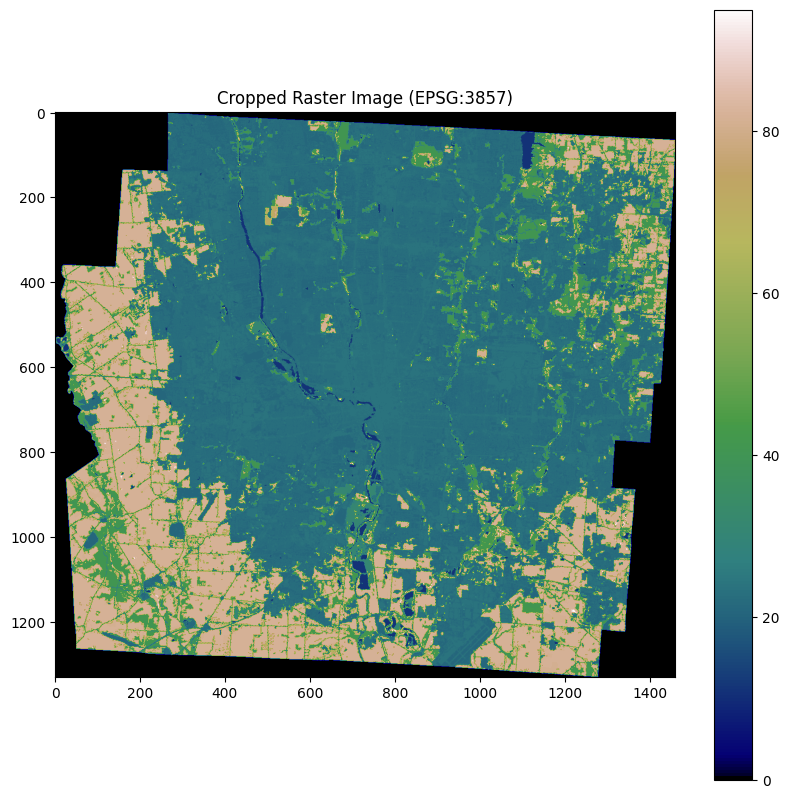

In [11]:
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Polygon, Point
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.ops import transform
import random
import requests
from io import BytesIO
from zipfile import ZipFile
import tempfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import zipfile

# Define the path to your shapefile or GeoJSON that defines the clipping area
tract_url = f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_39_tract.zip"
response = requests.request("GET", tract_url)
# Use BytesIO to handle the zip file in memory
with ZipFile(BytesIO(response.content)) as zip_ref:
    # Create a temporary directory to extract the zip file
    with tempfile.TemporaryDirectory() as tmpdirname:
        zip_ref.extractall(tmpdirname)
        
        # Find the shapefile or GeoJSON file in the extracted contents
        for root, dirs, files in os.walk(tmpdirname):
            for file in files:
                if file.endswith(".shp") or file.endswith(".geojson"):
                    file_path = os.path.join(root, file)
                    # Load the file into a GeoDataFrame
                    clipping_shape = geopandas.read_file(file_path)

dst_crs = 'EPSG:3857'  # Define your target CRS
clipping_shape = clipping_shape.to_crs(dst_crs)
clipping_shape = clipping_shape[clipping_shape['COUNTYFP'] == "049"]
print("Shapefile CRS:", clipping_shape.crs)

import zipfile
import rasterio
import matplotlib.pyplot as plt
import os

# Path to the zip file and the image files inside it
zip_path = 'nlcd_2021_land_cover_l48_20230630.zip'
img_filename = 'nlcd_2021_land_cover_l48_20230630.img'
ige_filename = 'nlcd_2021_land_cover_l48_20230630.ige'

# Extract the image files temporarily
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extract(img_filename, 'temp_extracted')
    zip_ref.extract(ige_filename, 'temp_extracted')

# Open the extracted image file with rasterio
"""
with rasterio.open(os.path.join('temp_extracted', img_filename)) as dataset:

    # Read the data from the window
    band1 = dataset.read(1, window=window)

    # Plot the raster
    plt.figure(figsize=(10, 10))
    plt.imshow(band1, cmap='viridis')
    plt.title('Raster Image')
    plt.colorbar()
    plt.show()
"""
with rasterio.open(os.path.join('temp_extracted', img_filename)) as src:
    # Define the target CRS (EPSG:3857)
    dst_crs = 'EPSG:3857'
    
    # Calculate the transform and new dimensions of the reprojected raster
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Define the metadata for the destination raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Create a memory file or a new file to save the reprojected raster
    with rasterio.open('reprojected_image.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
    
    # Open the reprojected image
    with rasterio.open('reprojected_image.tif') as reprojected_src:
        # Convert the GeoDataFrame to a list of geometries
        geometries = clipping_shape.geometry.values
        
        # Mask the raster with the GeoDataFrame geometries (crop)
        out_image, out_transform = mask(reprojected_src, geometries, crop=True)
        
        # Update the metadata with new dimensions and transform
        out_meta = reprojected_src.meta.copy()
        out_meta.update({
            'height': out_image.shape[1],
            'width': out_image.shape[2],
            'transform': out_transform
        })
    
    # Plot the cropped raster
    plt.figure(figsize=(10, 10))
    plt.imshow(out_image[0], cmap='gist_earth')  # Assuming single band raster
    plt.title('Cropped Raster Image (EPSG:3857)')
    plt.colorbar()
    plt.show()

with rasterio.open('Franklin_Raster.tif', 'w', **out_meta) as dst:
        dst.write(out_image)

# Clean up the extracted files (optional)
os.remove(os.path.join('temp_extracted', img_filename))
os.remove(os.path.join('temp_extracted', ige_filename))
os.rmdir('temp_extracted')